In [9]:
from tqdm import tqdm

from tools.analysis_utils import (
    import_known_tokens,
    compile_scores,
    convert_raw,
    vjui
)

from pandas import DataFrame, Series
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [10]:
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")


In [11]:
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()

# Analyse sur le hors domaine textes tardifs

## Lien Texte / URN

In [12]:
data = """Tertullien, De pallio, III (570 mots) : urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3
Tertullien, De spectaculis, IX-X (642 mots) : urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10
Grégoire de Tours, Historia Francorum, II, 30-31 (548 mots) : urn:cts:latinLit:stoa0143.stoa001:@.30-2.31
Augustin, De civitate Dei, XVII, 4 (555 mots) : urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4
Augustin, Lettre CCLXII, 1-4 (582 mots) : urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4
Sulpice Sévère, Vita Martini, IX-X (519 mots) : urn:cts:latinLit:stoa0270.stoa002.opp-lat2:9-10
Prudence, Psychomachie, préface et 1-20 (519 mots) : urn:cts:latinLit:stoa0238.stoa002.perseus-lat2:pr.1-1.20
Commodien, Instructiones, I, 35-37 (432 mots) : urn:cts:latinLit:stoa0096.stoa003.opp-lat2:1.35-1.37
Cyprien de Carthage, De unitate Ecclesiae, VI-VIII (663 mots) : urn:cts:latinLit:stoa0104a.stoa010.opp-lat1:6-8
Salvien de Marseille, De gubernatione Dei, VI, 10-11 (540 mots) : urn:cts:latinLit:stoa0249a.stoa002.opp-lat1:6.53-6.60
Jean Cassien, Institutiones, VIII, 8-10 (553 mots) : urn:cts:latinLit:stoa0076c.stoa002.opp-lat2:8.8-8.10
Sidoine Apollinaire, Lettres, IV, 3 (730 mots) :  urn:cts:latinLit:stoa0261.stoa002:4.3
Ambroise de Milan, De Tobia, 1-8 (576 mots) : urn:cts:latinLit:stoa0022.stoa044.opp-lat1:1-8
Bède le Vénérable, De locis sanctis, I-II (647 mots) : urn:cts:latinLit:stoa0054.stoa001a.opp-lat1:1-2
Hilaire de Poitiers, Tractatus super psalmos, II, 1-4 (600 mots) : urn:cts:latinLit:stoa0149b.stoa001.opp-lat1:2
Lactance, De mortibus persecutorum, 26-27 (579 mots) : urn:cts:latinLit:stoa0171.stoa002.opp-lat1:26-27
Jérôme, Commentaire sur Jérémie, I, 1, 1-2, 3 (514 mots) : urn:cts:latinLit:stoa0162.stoa024.opp-lat1:1.1.1-1.2.3
Boèce, Contra Eutychen et Nestorium, III (714 mots) : urn:cts:latinLit:stoa0058.stoa023.perseus-lat1:3
Eginhard, Vie de Charlemagne, I-III (631 mots) : urn:cts:latinLit:stoa0112.stoa001:1-3""".split("\n")

TextsTitles = dict([("urn:"+line.split("urn:")[-1], (",".join(line.split(",")[:2]).split("(")[0])) for line in data])
print(TextsTitles)

{'urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3': 'Tertullien, De pallio', 'urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10': 'Tertullien, De spectaculis', 'urn:cts:latinLit:stoa0143.stoa001:@.30-2.31': 'Grégoire de Tours, Historia Francorum', 'urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4': 'Augustin, De civitate Dei', 'urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4': 'Augustin, Lettre CCLXII', 'urn:cts:latinLit:stoa0270.stoa002.opp-lat2:9-10': 'Sulpice Sévère, Vita Martini', 'urn:cts:latinLit:stoa0238.stoa002.perseus-lat2:pr.1-1.20': 'Prudence, Psychomachie', 'urn:cts:latinLit:stoa0096.stoa003.opp-lat2:1.35-1.37': 'Commodien, Instructiones', 'urn:cts:latinLit:stoa0104a.stoa010.opp-lat1:6-8': 'Cyprien de Carthage, De unitate Ecclesiae', 'urn:cts:latinLit:stoa0249a.stoa002.opp-lat1:6.53-6.60': 'Salvien de Marseille, De gubernatione Dei', 'urn:cts:latinLit:stoa0076c.stoa002.opp-lat2:8.8-8.10': 'Jean Cassien, Institutiones', 'urn:cts:latinLit:stoa0261.stoa002:4.3': 'Sidoine Apol

## Import des données

In [13]:
Texts = []
GOLD = []

Milestones = set(list(range(0, 14226)) + list(range(20384, 24732)))
nb_tokens = 0

def filter_gold(data):
    return [lst for lst in data if lst]


import regex

punkts = regex.compile(r"\W+")
greek = regex.compile(r"\p{Greek}+")

def keep_tokens(token):
    if greek.match(token):
        print(token)
        return False
    return True


with open("/home/thibault/dev/latin-non-classical-data/latin-chretien-v2.tsv") as f:
    header = []
    current_text = None
    for lineno, line in enumerate(f):
        line = line.strip().split("\t")
        if lineno == 0:
            header = line
            continue
            
        if lineno not in Milestones:
            continue
        
        line = dict(zip(header, line))
        
        if line["form"].startswith("urn:"):
            GOLD = filter_gold(GOLD)
            Texts.append((line["form"], nb_tokens, len(GOLD)))
            GOLD.append([])
            continue
        
        if line["POS"] == "PUNC":
            if line["lemma"] in ".!?":
                if GOLD[-1] != []:
                    GOLD = filter_gold(GOLD)
                    GOLD.append([])
        elif keep_tokens(line["form"]):
            GOLD[-1].append(line)
            nb_tokens += 1
            

if GOLD[-1] == []:
    GOLD = GOLD[:-1]
print(f"{len(Texts)} texts found")
print(f"{len(GOLD)} sentences found")
TextsLengths = {
    
}
# Compute texts Lengths
for cur, nxt in zip(Texts, Texts[1:] + [None]):
    if nxt is None:
        TextsLengths[cur[0]] = nb_tokens - cur[1]
    else:
        TextsLengths[cur[0]] = nxt[1] - cur[1]
# Update titles
#TextsTitles = {
#    urn: f"{title} ({TextsLengths.get(urn, '?')} mots)"
#    for urn, title in TextsTitles.items()
#}
print(TextsTitles)
if False:
    for tok in GOLD[0]:
        print(tok)
    for text in Texts:
        print(text)

νοῦς
ὑπόστασιν
πρόσωπα
παρὰ 
τοῦ 
πρὸς 
τοὺς
ὦπας
τίθεσθαι
πρόσωπα
ὑποστάσεως
ὑπόστασιν
ὑπόστασιν
αἱ 
οὐσίαι
ἐν 
μὲν
τοῖς 
καθόλου 
εἶναι
δύνανται
ἐν
δὲ
τοῖς
ἀτόμοις
καὶ
κατὰ
μέρος
μόνοις
ὑφίστανται
ὑποστάσεις
οὐσίωσιν
οὐσιῶσθαι
ὑπόστασιν
ὑφίστασθαι
εἶναι
οὐσιῶσθαι
ὑφίστασθαι
οὐσίαν
οὐσίωσιν
ὑπόστασιν
πρόσωπον
ὑποστάσεις
ὑποστάσεις
πρόσωπα
οὐσίαν
οὐσίωσιν
ὑπόστασιν
πρόσωπον
ὑπόστασιν
ὑφίστασθαι
ὑποστάσεως
οὐσία
οὐσίωσις
ὑπόστασις
πρόσωπον
οὐσία
οὐσίωσις
ὑπόστασις
οὐσίωσεις
πρόσωπον
οὐσία
οὐσίωσις
ὑφίστασθαι
οὐσίαν
οὐσίωσιν
ὑποστάσεις
οὐσιῶσθαι
19 texts found
728 sentences found
{'urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3': 'Tertullien, De pallio', 'urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10': 'Tertullien, De spectaculis', 'urn:cts:latinLit:stoa0143.stoa001:@.30-2.31': 'Grégoire de Tours, Historia Francorum', 'urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4': 'Augustin, De civitate Dei', 'urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4': 'Augustin, Lettre CCLXII', 'urn:ct

## Transformation et expansion des champs 

In [14]:
PLATINUM = convert_raw(GOLD, task_list=TASKS, lemma_fn=vjui, form_fn=vjui, 
                       pos_fn=lambda x:x) # remove if POS does not use PRO and COM

100%|██████████| 728/728 [00:00<00:00, 11933.57it/s]


## Récupération des tokens uniquement


In [15]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]

## Test

In [16]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
#MODEL_PATH = "../../../pie/models/FinalModelVulgate-lemma-2020_10_14-18_09_35.tar"
MODEL_PATH = "../../../latin-lasla-models/model.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=False, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

8it [00:16,  2.01s/it]


In [17]:
#tasks
#OUTPUT

## Compilation des résultats

In [18]:
from collections import defaultdict, Counter


RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS
)

# Scores

## Scores généraux

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.3f}".format(accuracy_score(truth, pred)),
        "{0:.3f}".format(accuracy_score(pred_limited, truth_limited))
    ])
print(tabulate(data))

print(DataFrame(data).to_latex())

----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.946     0.946
Deg               0.976     0.920
Numb              0.965     0.965
Person            0.997     0.991
Mood_Tense_Voice  0.977     0.923
Case              0.928     0.880
Gend              0.950     0.878
pos               0.674     0.674
----------------  --------  ------------------
\begin{tabular}{llll}
\toprule
{} &                 0 &         1 &                   2 \\
\midrule
0 &              Task &  Accuracy &  Accuracy on V != \_ \\
1 &             lemma &     0.946 &               0.946 \\
2 &               Deg &     0.976 &               0.920 \\
3 &              Numb &     0.965 &               0.965 \\
4 &            Person &     0.997 &               0.991 \\
5 &  Mood\_Tense\_Voice &     0.977 &               0.923 \\
6 &              Case &     0.928 &               0.880 \\
7 &              Gend &     0.950 &               0.878 \\
8 &         

```
----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.951     0.951
Deg               0.977     0.940
Numb              0.972     0.969
Person            0.998     0.994
Mood_Tense_Voice  0.978     0.922
Case              0.932     0.883
Gend              0.888     0.629
pos               0.947     0.947
----------------  --------  ------------------
```

## Établissement d'une liste des confusions

In [20]:
ERRORS["lemma"]

with open("1.4.X-LatinTardif-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    print("lemma\tprediction\ttoken\tnumber")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")
                print(f"{lemma}\t{pred}\t{token}\t{count}")

lemma	prediction	token	number
cataclita	cataxlestus	cataclistis	1
syrma	syrmates	syrmate	1
hyaena	Hyaena	Hyaenam	1
pascor	pasco	pastus	1
tardigradus	tardigra	tardigrada	1
oppido	oppidum	oppido	1
chamaeleon	Chamaeleon	Chamaeleontem	1
chamaeleon	Chamaele	Chamaeleon	1
chamaeleon	chamaele	chamaeleon	1
chamaeleon	chamaeles	chamaeleonti	1
amplus	ample	amplius	1
quod	qui	quod	14
quod	quis	quod	1
uertigino	uertigo	uertiginant	1
inuestis	inuestus	inuestis	1
licitus	licet	licitum	1
licitus	licet	licita	1
qui	quod	quod	19
qui	quod	Quod	2
qui	quis	Quas	1
qui	quis	quo	1
qui	quis	qui	1
qui	quo	quo	3
qui	quam	quam	1
Osiris	Osirides	Osiridis	1
Ammon	ammon	Ammon	1
palpo	palpatus	palpati	1
lanitium	lanicia	lanicii	1
Arachne	Arachnes	Arachnen	1
Baetica	Baeticus	Baetica	1
lautus	plautus	plautiores	1
aer	aes	aerem	1
liquo	liquor	liquando	1
idonee	idone	idonius	1
uestificina	uestificium	uestificinae	1
qua	qui	qua	1
exsertus	exsero	exertus	1
Graeci	Graecus	Graecis	1
daemonium	daemonius	daemoniorum	1
daemoniu

# Visualisation sur le corpus

In [21]:
MilestonesSentences = [
    (tid, begin, end)
    for (tid, _, begin), (_, _, end) in zip(Texts, Texts[1:]+[(None, None, None)])
] # Those are sentences IDs

def count_tokens(begin, end):
    return len([tok for sent in PLATINUM[begin:end] for tok in sent])

MILESTONES = [count_tokens(beg, end) for _, beg, end in MilestonesSentences]
MILESTONES = [sum(MILESTONES[:index]) + value for index, value in enumerate(MILESTONES)]

SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
SIZES = []


lengths = []
support_done = False
for task, (pred, truth) in RAW_SCORES.items():
    ms_start = 0
    for milestone in MILESTONES:
        SPLITS_TASK[task].append(accuracy_score(truth[ms_start:milestone], pred[ms_start:milestone]))
        length = milestone - ms_start + 1
        if not support_done:
            SIZES.append(length)
        ms_start = milestone
    support_done = True

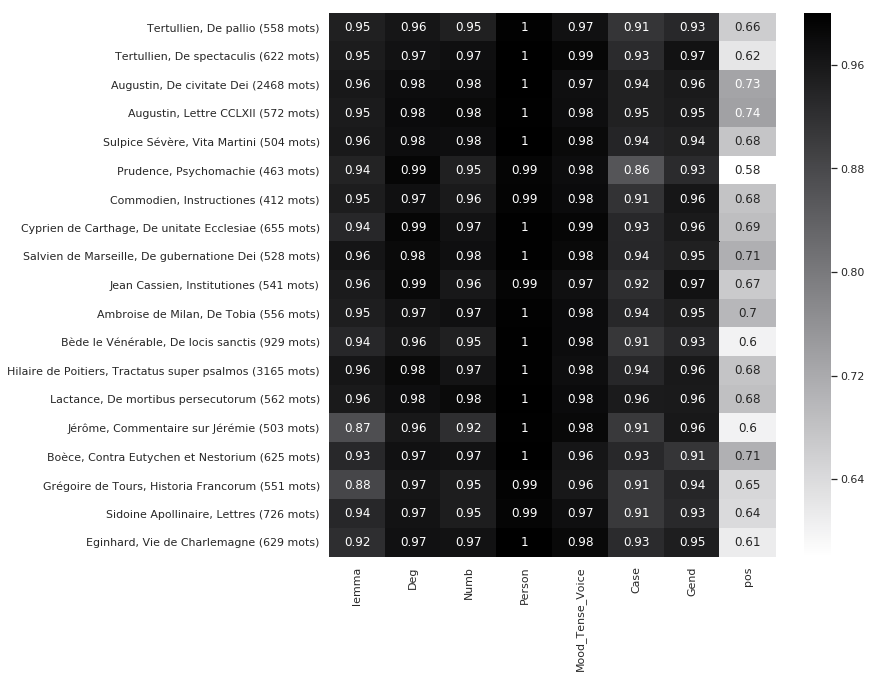

In [22]:


sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

DF_Tardif = DataFrame(SPLITS_TASK, index=[
    "{} ({} mots)".format(TextsTitles[tid], length) for (tid, *_), length in zip(MilestonesSentences, SIZES)
])

plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_Tardif, annot=True, cmap=cmap)


## Visualisation sur le corpus par POS GOLD

### Recompilation PLATINUM avec NOMpro / NOMcom

In [23]:
PLATINUM_NOMpro = convert_raw(GOLD, task_list=TASKS, lemma_fn=vjui, form_fn=vjui, pos_fn=lambda x: x)

100%|██████████| 728/728 [00:00<00:00, 13336.36it/s]


In [24]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(lambda :defaultdict(list))
_, Scores_Nom_Pro, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM_NOMpro, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                    known_lemmas=KNOWN_LEMMAS)


start = 0
for text_id, end in enumerate(MILESTONES):
    for (lemma_pred, lemma_truth,  pos_truth) in zip(
        Scores_Nom_Pro["lemma"][0][start:end],
        Scores_Nom_Pro["lemma"][1][start:end],
        Scores_Nom_Pro["pos"][1][start:end]
    ):
        Stats_Per_Pos[text_id][pos_truth].append(int(lemma_pred == lemma_truth))
    start = end

## Now we compute the accuracy and the weight of each POS (in %)

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


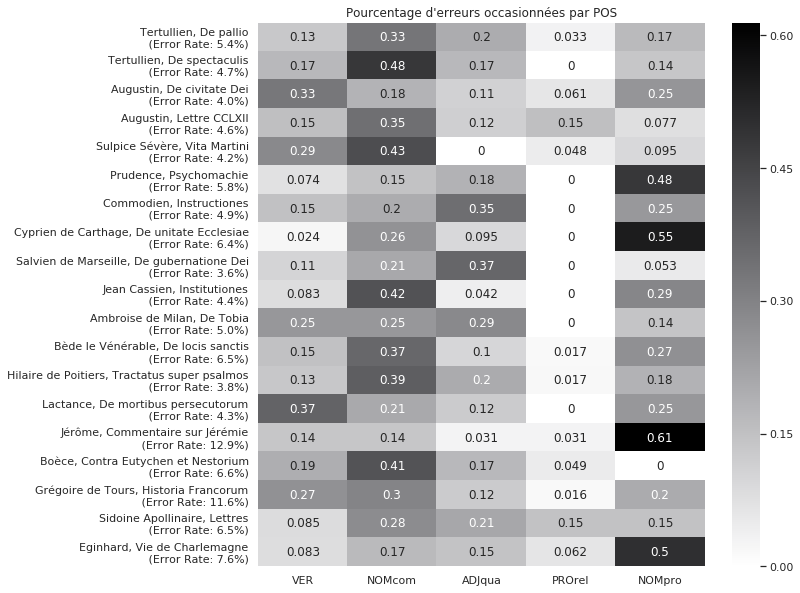

In [25]:
from collections import namedtuple
TextInformation = namedtuple("TextInformation", ["title", "size", "error_rate"])
TextTitleSize = [
    TextInformation(TextsTitles[tid], length, 1-accuracy) 
    for (tid, *_), length, accuracy in zip(
        MilestonesSentences, SIZES, SPLITS_TASK["lemma"]
    )
]

LIMIT_TO_POS = {"VER", "NOMcom", "NOMpro", "PROrel", "ADJqua"}


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

Impact_Acc_Per_Pos = DataFrame({
    f"{TextTitleSize[text_id].title}\n (Error Rate: {TextTitleSize[text_id].error_rate*100:.1f}%)": {
        pos: compute_accuracy(equals, TextTitleSize[text_id].size, TextTitleSize[text_id].error_rate)
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
    }
    for text_id, texts_values in Stats_Per_Pos.items()
}).transpose()


# Impact_Acc_Per_Pos[f"Total {len(LIMIT_TO_POS)} POS"] = Impact_Acc_Per_Pos[f"Total {len(LIMIT_TO_POS)} POS"].sum()

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig = plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(Impact_Acc_Per_Pos, annot=True, cmap=cmap)
ax.set_title("Pourcentage d'erreurs occasionnées par POS")
fig.show()

### Impact on Accuracy vs. Size in Corpus

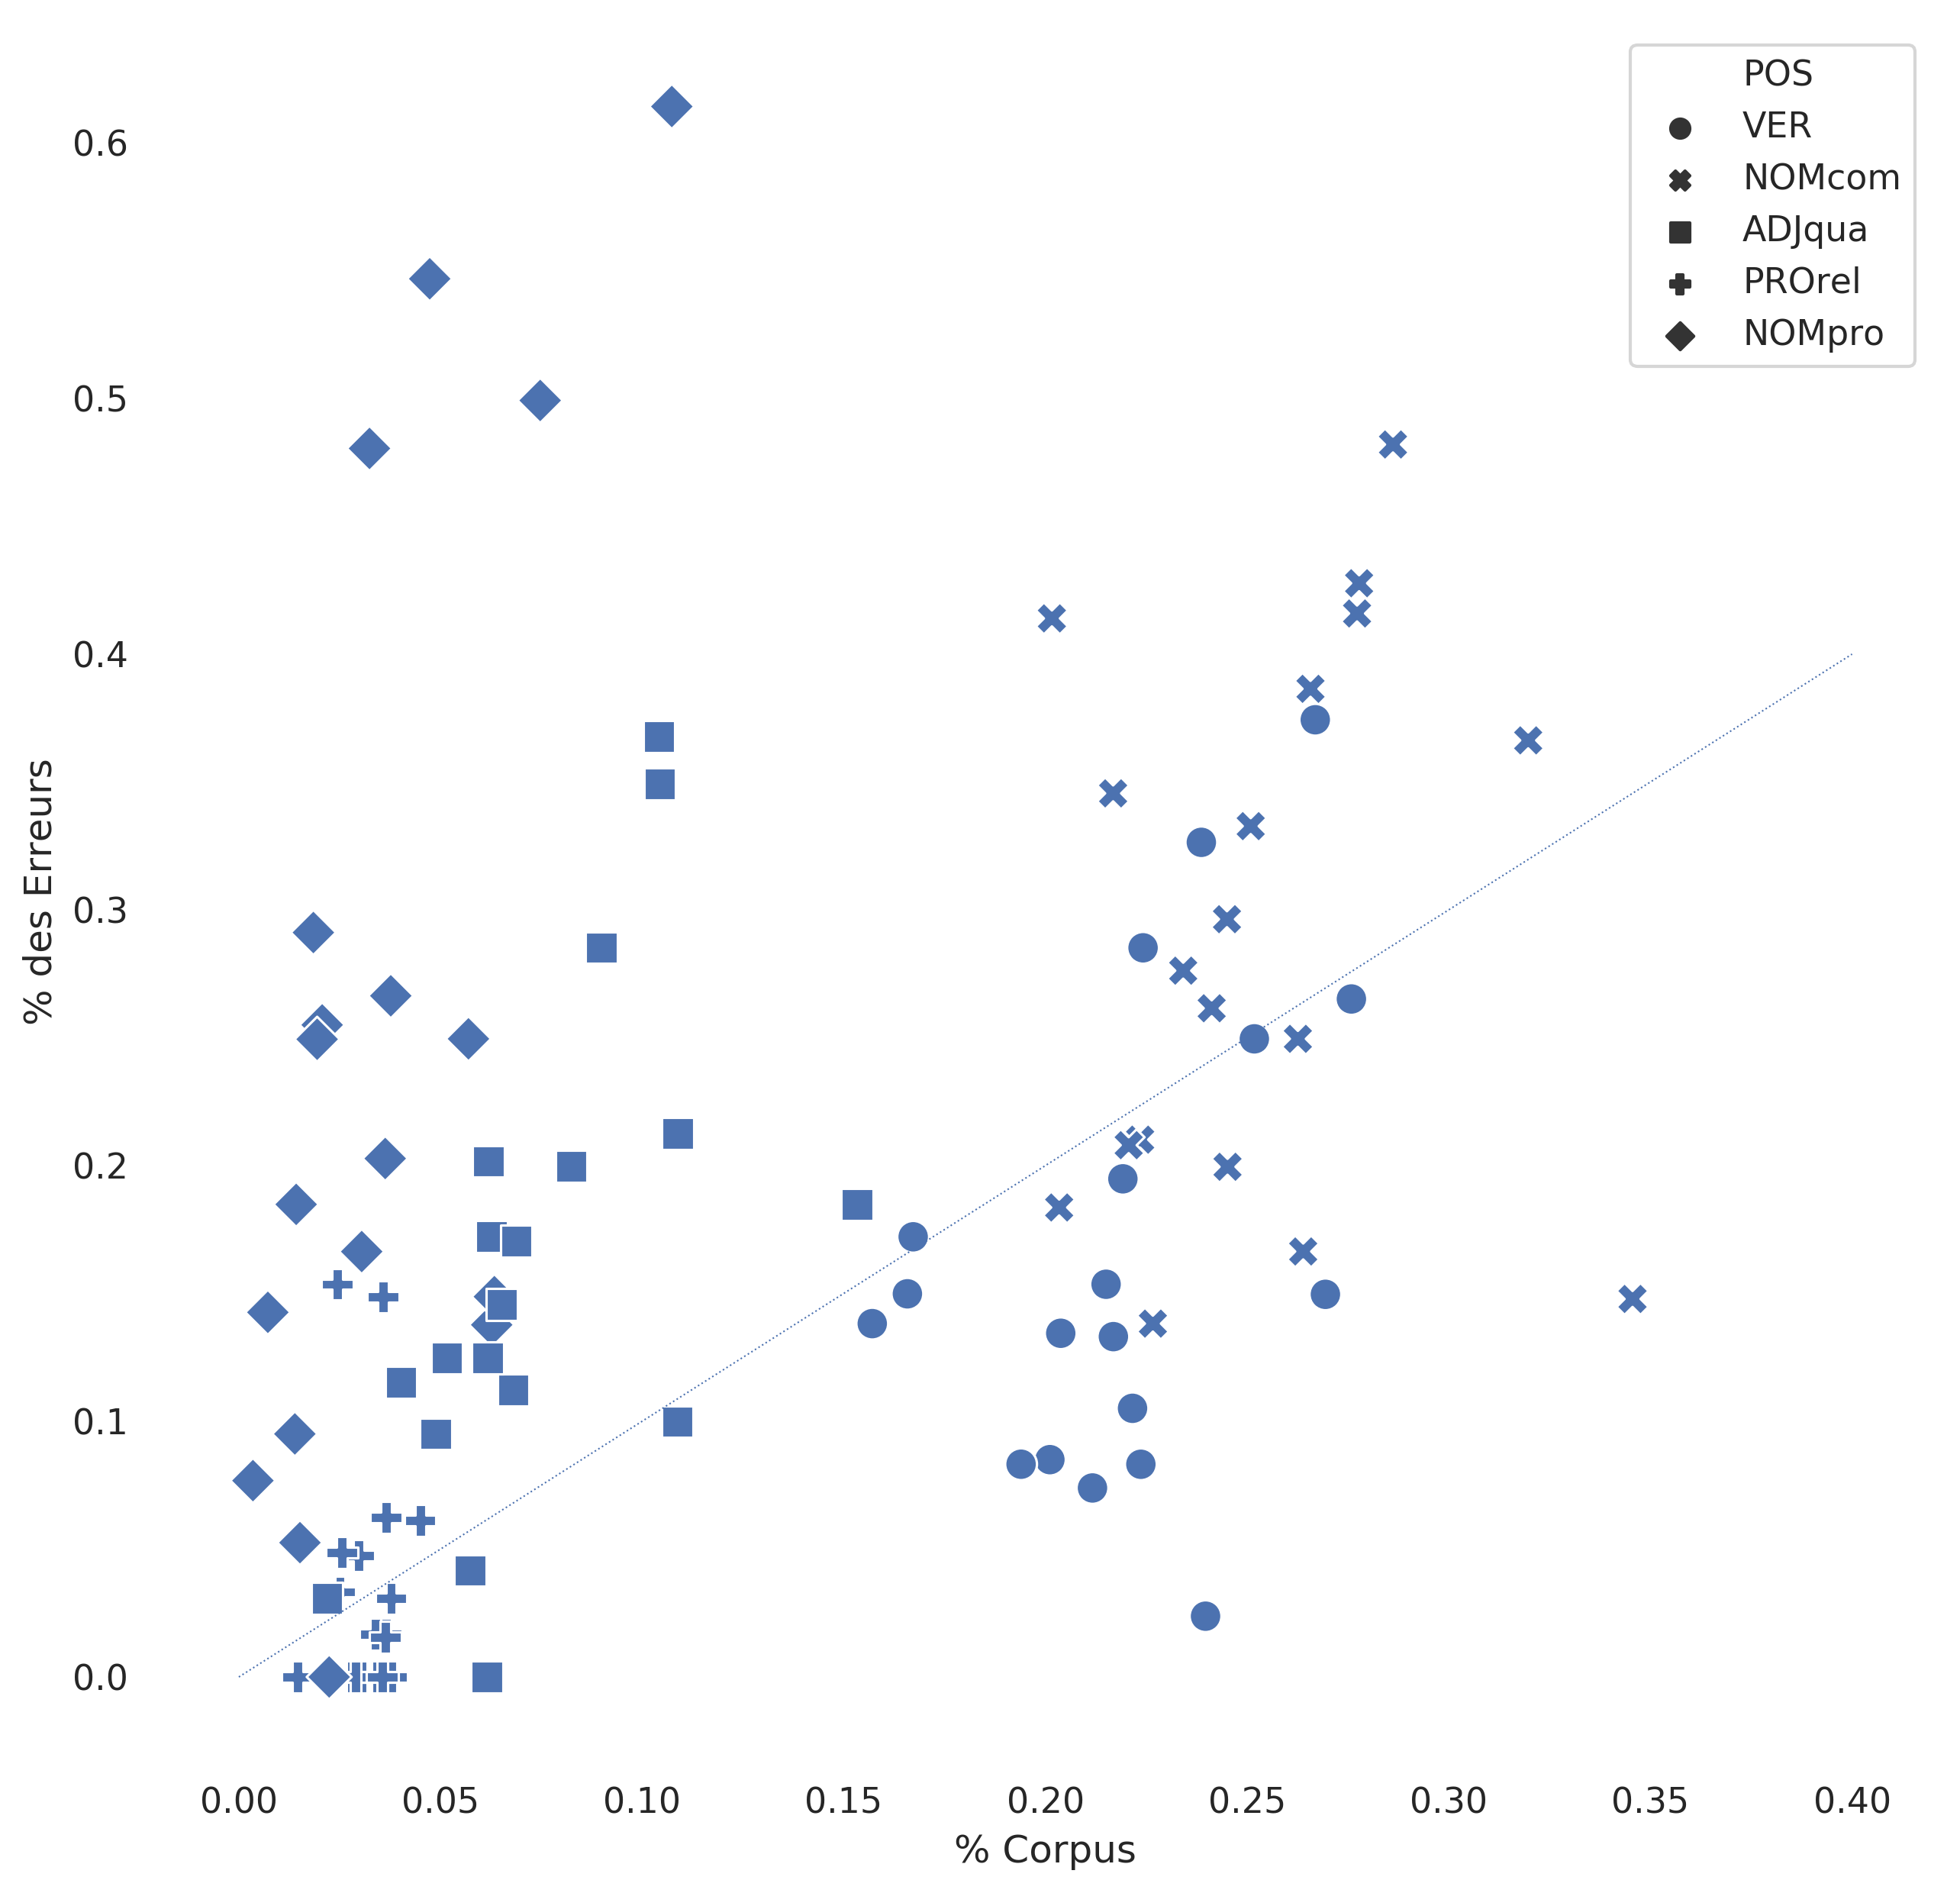

In [26]:
ScatterPos = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
])
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax = sns.scatterplot(
    x="% Corpus", y="% des Erreurs", style="POS", s=100,
    data=ScatterPos, 
    cmap=sns.husl_palette(len(LIMIT_TO_POS)),
    ax=ax
)
# Plot distribution normale
import numpy as np
x = np.linspace(0, 0.4)
plt.plot(x, x, linestyle=':', linewidth=0.5)

ax.plot()
fig.show()

#### As boxplot

6.84353741496599
1.1456790123456781
1.1456790123456781
            % Corpus  % des Erreurs     Impact
POS                                           
ADJadv.mul  0.002543       0.000000        NaN
ADJadv.ord  0.001792       0.000000  11.553609
ADJcar      0.007065       0.000000   2.792969
ADJdis      0.001988       0.000000        NaN
ADJmul      0.001567       0.000000   1.205008
ADJord      0.004226       0.000000   1.863417
ADJqua      0.065183       0.145601   1.029509
ADV         0.059203       0.008401   1.539796
ADVint      0.002171       0.000000   1.422170
ADVint.neg  0.001127       0.000000   3.255702
ADVneg      0.010753       0.000000   1.702889
ADVrel      0.007937       0.000000   1.817044
CONcoo      0.063593       0.000000   1.500000
CONsub      0.035120       0.016649   5.460784
INJ         0.002138       0.000000   1.058348
NOMcom      0.245146       0.276215   2.421739
NOMpro      0.030466       0.202756   2.153246
PRE         0.066543       0.000000   1.326190
PROde

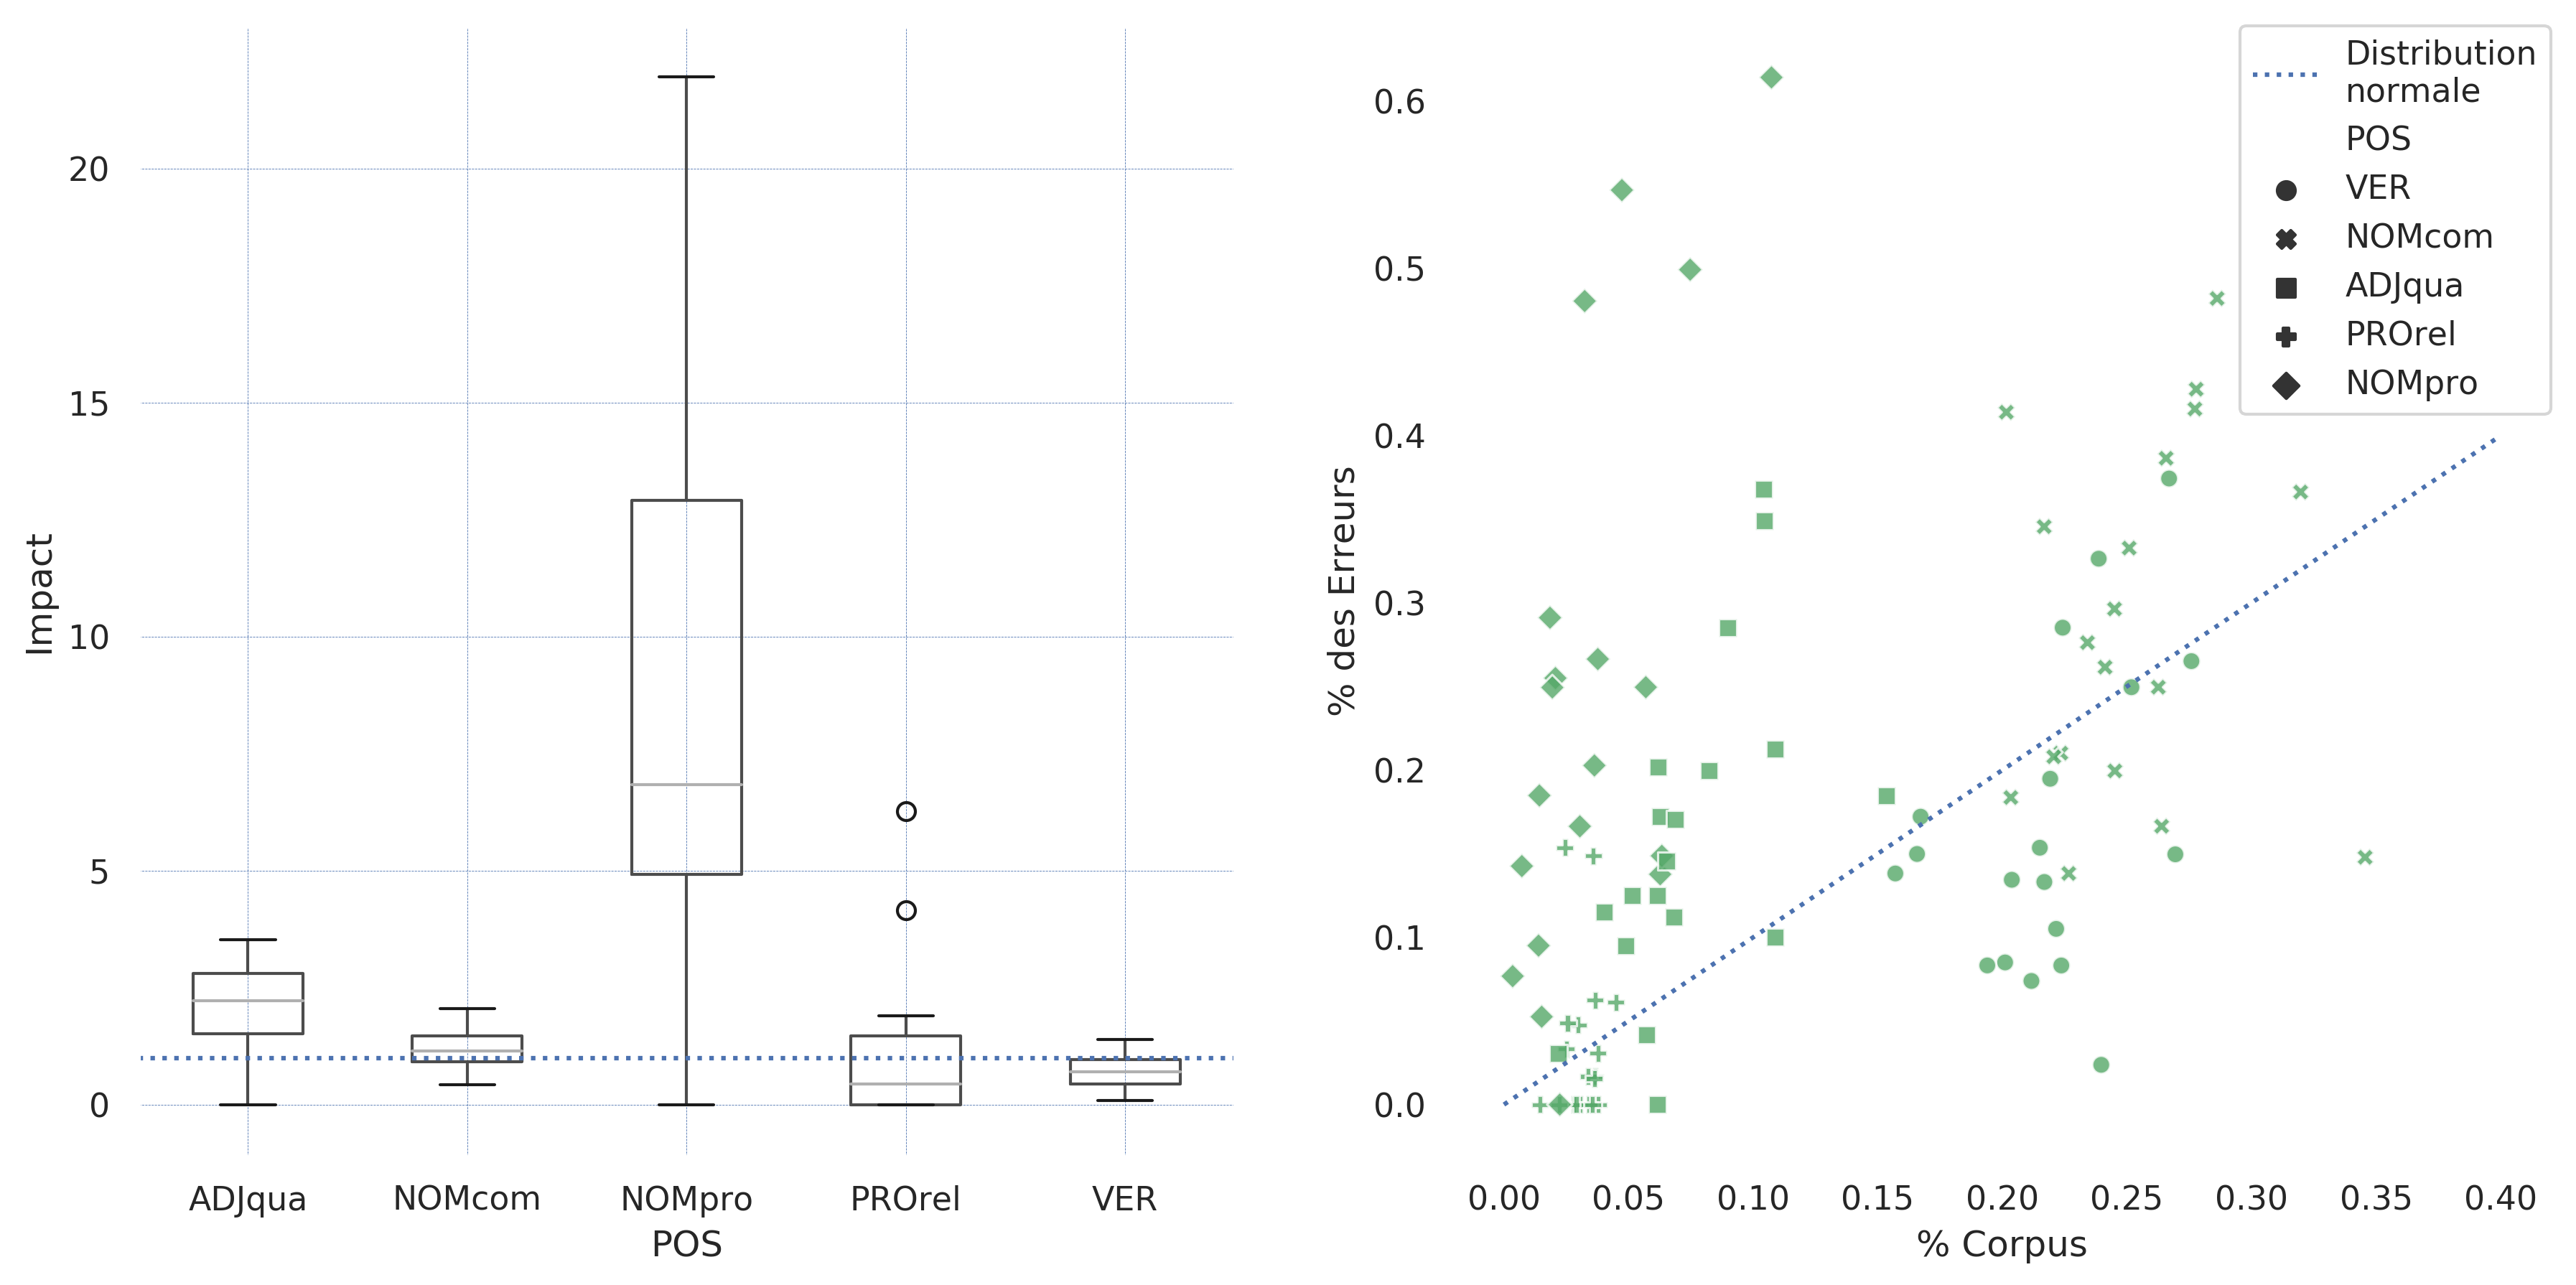

In [27]:
ScatterPos = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
])
ScatterPos["Impact"] = ScatterPos["% des Erreurs"] / ScatterPos["% Corpus"] 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), dpi=300)
# Draw plotbot
ScatterPos.boxplot(ax=ax1, column="Impact", by="POS")
ax1.set_title(label="")
ax1.axhline(y=1, label="Distribution normale", linestyle=":")
ax1.set_ylabel("Impact")
# ax1.text(y=0.8, x=5.6, s="Distribution\nnormale")
ax1.grid(True, color='b', linestyle='--', linewidth=0.2)

# Draw scatter
ax2 = sns.scatterplot(
    x="% Corpus", y="% des Erreurs", style="POS", 
    data=ScatterPos, alpha=0.8,
    color="g",
    ax=ax2
)
x = np.linspace(0, 0.4)
line = ax2.plot(x, x, linestyle=':', color="b", label="Distribution\nnormale")
# line_patch = mpatches.Patch(color='blue', linestyle="--", label="Distribution\nnormale")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0, handles=handles)

fig.suptitle("")
fig.show()

nompro =  ScatterPos.loc[ScatterPos["POS"]=="NOMpro"]["Impact"]
print(nompro.median())#, nompro)
nomcom =  ScatterPos.loc[ScatterPos["POS"]=="NOMcom"]["Impact"]
print(nomcom.median())#, nomcom)
ver =  ScatterPos.loc[ScatterPos["POS"]=="VER"]["Impact"]
print(nomcom.median())#, nomcom)

FullDistrib = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
])
FullDistrib["Impact"] = ScatterPos["% des Erreurs"] / ScatterPos["% Corpus"]
FDGB = FullDistrib.groupby("POS").median()
print(FDGB)

### Impact on Accuracy vs. Size in Corpus

We remove PROrel because they are all known

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


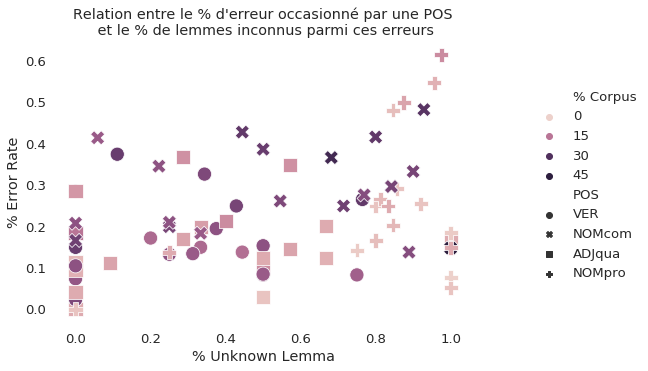

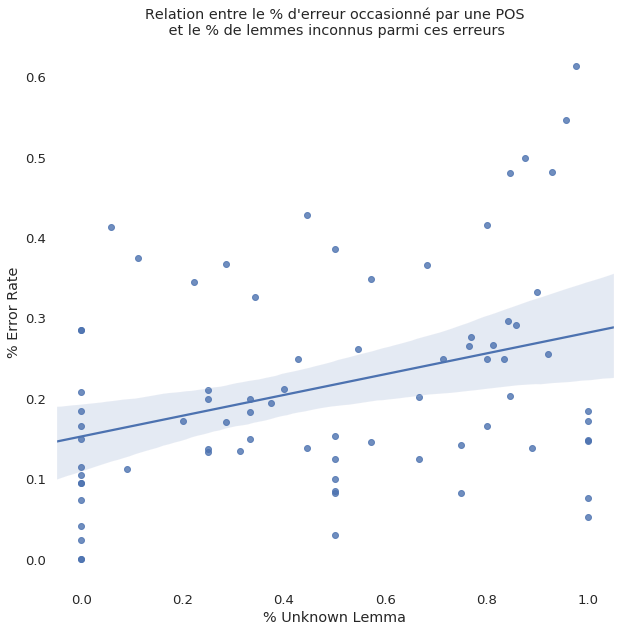

In [28]:
# Compile data to take into account LEMMA and POS
LIMIT_TO_POS_UNKNOWN = {"VER", "NOMcom", "NOMpro", "ADJqua"}
LemmaPosUnknown = defaultdict(lambda :defaultdict(lambda: defaultdict(list)))
start = 0


for text_id, end in enumerate(MILESTONES):
    for token in Score_Knowns[start:end]:
        LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["Accuracy"].append(int(token["lemma"]))
        
        if not token["lemma"]:  # If lemmatization is wrong
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownTokens"].append(
                int(token["known_token"])
            )
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownLemmas"].append(
                int(token["known_lemma"])
            )
    start = end
    
def compute_rate_unknown(score, key):
    if score[key]:
        return 1 - sum(score[key]) / len(score[key])
    return 0

LemmaPosUnknownDataFrame = DataFrame([
    {
        "POS": pos,
        "% Error Rate": compute_accuracy(
            score["Accuracy"],
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        ),
        "% Unknown Tokens": compute_rate_unknown(score, "KnownTokens"),
        "% Unknown Lemma": compute_rate_unknown(score, "KnownLemmas"),
        "% Corpus": round(100*len(score["Accuracy"])/TextTitleSize[text_id].size)
    }
    for text_id, text_values in LemmaPosUnknown.items()
    for pos, score in text_values.items()
    if pos in LIMIT_TO_POS_UNKNOWN
])

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.relplot(
        x="% Unknown Lemma", y="% Error Rate", style="POS", 
        hue="% Corpus", s=200,
        data=LemmaPosUnknownDataFrame, 
        cmap=sns.husl_palette(len(LIMIT_TO_POS))
    )
    g.fig.set_size_inches(10,5)
    g.fig.axes[0].set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    g.fig.show()
    
with sns.plotting_context("notebook", font_scale=1.2):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.regplot(
        x="% Unknown Lemma", y="% Error Rate",
        data=LemmaPosUnknownDataFrame,
        ax=ax
    )
    ax.set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    fig.show()

## Visualisation du texte et des erreurs

In [29]:
from IPython.core.display import display, HTML

THRESHOLD = 0.97

pred, truth = RAW_SCORES["lemma"]
pos_pred, pos_truth = RAW_SCORES["pos"]
flatten_tokens = [tok for sent in TOKENS for tok in sent]
ms_start = 0

annotate_pos = False

full = ""
for nice_title, ms_start, ms_end in zip(TextTitleSize, [0] + MILESTONES, MILESTONES):
    text = []
    nb_tokens = ms_end - ms_start
    size = 1 / nice_title.size
    nb_errors_lemma = 0
    nb_errors_pos = 0
    annotate = "lemma"
    for tok, l_t, l_p, p_t, p_p in zip(
        flatten_tokens[ms_start:ms_end], 
        truth[ms_start:ms_end], pred[ms_start:ms_end],
        pos_truth[ms_start:ms_end], pos_pred[ms_start:ms_end]
    ):
        if l_t == l_p and p_t == p_p:
            text.append(tok)
            continue
            
        annotation = f""
        if l_t != l_p:
            if annotate == "lemma":
                annotation += f"<span class='annotation'><span style='font-style:italic;'>{tok}</span>" +\
                f"[<span style='color:green;'>{l_t}</span>,<span style='color:red;'>{l_p}</span>]</span>"
            nb_errors_lemma += 1
        if p_t != p_p:
            if annotate == "pos":
                annotation += f"<span class='annotation'><span style='font-style:italic;'>{tok}</span>" +\
                f"[<span style='color:green;'>{p_t}</span>,<span style='color:red;'>{p_p}</span>]</span>"
            nb_errors_pos += 1
        text.append(annotation)
            
    text = "<p>"+" ".join(text).replace(" -", "-") + "</p>"
    text = f"""<h2>{nice_title.title}</h2>
    <p>
        <small>
        <b>Accuracy:</b> {accuracy_score(truth[ms_start:ms_end], pred[ms_start:ms_end]):.3f} <br />
        <b>Tokens:</b> {ms_end - ms_start}<br />
        <b>Errors Lemma: </b> {nb_errors_lemma}<br />
        <b>Errors POS: </b> {nb_errors_pos}<br />
        <b>1 error =</b> -{size*100:.1f} % drop in accuracy <br />
        <span style='color:green;'>Ground Truth</span> - <span style='color:red;'>Prediction</span>
        </small>
    </p>
    <p>{text}</p>
    """
    full += text
    display(HTML(text))
    
with open("latintardif.html", "w") as f:
    f.write(f"""<html>
    <head>
        <title>Export analyse</title>
        <meta charset="utf-8">
    </head>
    <body>
        {full}
    </body>
</html>""")


## Étude de ZIPF

Mots dans le quantile 99      33
Quantité de forme dans le Q99 4954
Quantité de mots              15550

        form         pos  count
1         et      CONcoo    556
47       qui      PROrel    509
41       sum         VER    430
57        in         PRE    398
381       is      PROdem    230
105      non      ADVneg    218
49       sum      VERaux    176
191      hic      PROdem    174
411     deus      NOMcom    136
198       ad         PRE    130
54        ut      CONsub    125
183     ille      PROdem    122
65        ab         PRE    122
91      suus  PROpos.ref    118
195     dico         VER    116
31      ipse      PROdem    111
10        de         PRE    107
111      sed      CONcoo    106
637  dominus      NOMcom    105
580      sui      PROref    104
125      cum      CONsub     87
328      per         PRE     84
247       ex         PRE     77
643     enim      CONcoo     76
250    facio         VER     70
494    autem      CONcoo     64
13     omnis      PROind     63

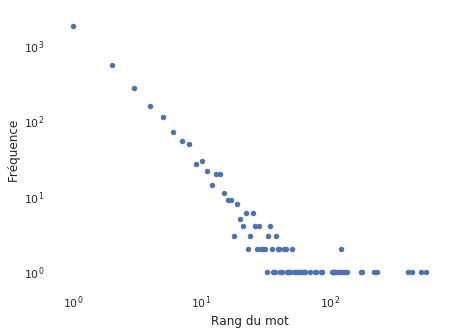

In [30]:
from collections import Counter
from pandas import Series, DataFrame

data = Counter([
    (annot["lemma"].lower(), annot["pos"])
    for sent in PLATINUM_NOMpro
    for annot in sent
])
counter_df = DataFrame([
    dict(zip(("form", "pos", "count"), (lem, pos, cnt))) 
    for (lem, pos), cnt in data.items()
])

reduced = counter_df[
    counter_df["count"] > counter_df["count"].quantile(0.99)
]
print(f'Mots dans le quantile 99      {reduced["count"].count()}')
print(f'Quantité de forme dans le Q99 {reduced["count"].sum()}')
print(f'Quantité de mots              {counter_df["count"].sum()}\n')
print(reduced.sort_values("count", ascending=False))
print(reduced.groupby(['pos']).size().sort_values(ascending=False))

## Drawing ZIPF plot

frequencies = DataFrame(
    [
        dict(zip(("Rang du mot", "Fréquence"), item))
        for item in Counter(
            sorted(list(data.values()))
        ).items()
    ]
)
fig, ax = plt.subplots(figsize=(7,5))
frequencies.plot.scatter(x="Rang du mot", y="Fréquence", logx=True, logy=True, ax=ax)